### Structure matrix from squares

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import shapely.geometry as geom


# Ignore FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Creating shapefile from squares

In [13]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
values = list(range(0, 16))

df = pd.DataFrame({'FIPS': box_names, 'Value': values})

In [14]:
# Sorting the DataFrame based on the 'rate' column
df.sort_values(by='Value', inplace=True)

In [15]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    box_name = row['FIPS']
    value = row['Value']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [16]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

In [17]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the CRS to a simple Cartesian coordinate system
gdf.crs = "EPSG:3395"  # This is a commonly used projected CRS

In [18]:
gdf

,FIPS,Value,geometry
0,A,0,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
1,B,1,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00..."
2,C,2,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."
3,D,3,"POLYGON ((3.000 0.000, 4.000 0.000, 4.000 1.00..."
4,E,4,"POLYGON ((0.000 1.000, 1.000 1.000, 1.000 2.00..."
5,F,5,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00..."
6,G,6,"POLYGON ((2.000 1.000, 3.000 1.000, 3.000 2.00..."
7,H,7,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00..."
8,I,8,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00..."
9,J,9,"POLYGON ((1.000 2.000, 2.000 2.000, 2.000 3.00..."


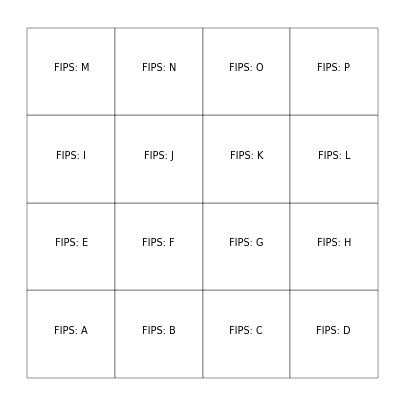

In [19]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_axis_off() 

for i, row in gdf.iterrows():
        centroid = row['geometry'].centroid
        text_to_display = f"FIPS: {row['FIPS']}"
        # plt.text(centroid.x, centroid.y, str(row['FIPS']), fontsize=15, ha='center', color="black")
        plt.text(centroid.x, centroid.y, text_to_display, fontsize=7, ha='center', color="black")

gdf.plot(ax=ax, edgecolor='black', linewidth=0.3, color="white")

plt.show()

In [24]:
# save gdf to a shapefile
gdf.to_file("./data/16 square shapefile/16squares.shp")

### PySAL

In [31]:
# Get points in a grid
l = numpy.arange(3)
xs, ys = numpy.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)

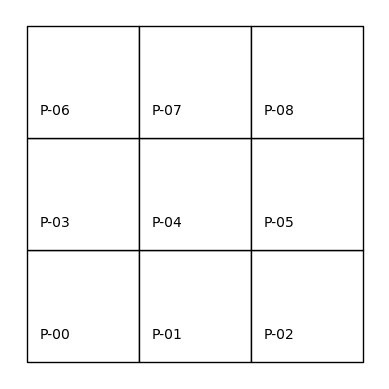

In [32]:
# Plot grid geotable
ax = gdf.plot(facecolor="w", edgecolor="k")

# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )

# Remove axes
ax.set_axis_off()
plt.show()

#### Rook contiguity matrix
https://geographicdata.science/book/notebooks/04_spatial_weights.html

In [27]:
import contextily
import geopandas
import rioxarray
import seaborn
import pandas
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry

In [33]:
from pysal.lib import weights

# Build a rook contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wr = weights.contiguity.Rook.from_dataframe(gdf)

In [34]:
wr

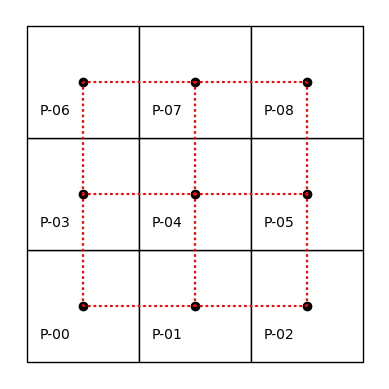

In [35]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

In [36]:
wr.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

In [37]:
pandas.DataFrame(*wr.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


In [38]:
wr.nonzero

24

The first row is not first for a specific mathematical reason; it just happens to be the first entry in the input. Here we use the alphanumeric ordering of the unit identifiers to match a polygon with a row or column of the matrix, but any arbitrary rule could be followed and the weights matrix would look different. The graph, however, would be isomorphic and retain the mapping of relationships.

#### Queen contiguity matrix


In [39]:
# Build a queen contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wq = weights.contiguity.Queen.from_dataframe(gdf)
wq.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

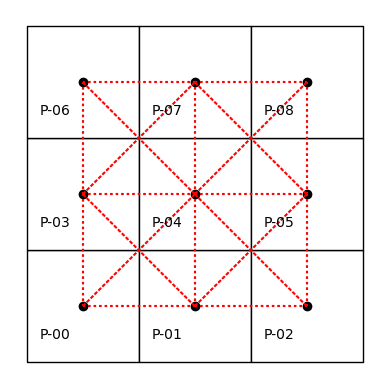

In [40]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

In [ ]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

In [42]:
pandas.DataFrame(*wq.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,1,0,0,0,0
1,1,0,1,1,1,1,0,0,0
2,0,1,0,0,1,1,0,0,0
3,1,1,0,0,1,0,1,1,0
4,1,1,1,1,0,1,1,1,1
5,0,1,1,0,1,0,0,1,1
6,0,0,0,1,1,0,0,1,0
7,0,0,0,1,1,1,1,0,1
8,0,0,0,0,1,1,0,1,0
